# Transcriptomic subtypes & Race relationship to cell proportions in Schildkraut HGSOC

We asked whether race modifies subtype-specific cell patterns, since it had been previously observed that Black patients had higher percentage of the Immunoreactive tumours compared to White. We tested this by fitting two-way ANOVAs (Subtype, Race and their interaction) to the same logit-transformed fractions.

- Results:  Adding race as a second factor did not materially change this picture: two-way ANOVA (Subtype × Race) showed that subtype remained a strong main effect for all four fractions (all p-adj ≤ 1.1 × 10⁻²), whereas race alone had no significant influence (all p-adj = 1).  Interaction terms were non-significant for adipocyte, immune and stromal compartments (all p-adj ≥ 0.75) and likewise non-significant for epithelial content (F = 2.45, p-adj ≈ 0.75). In summary, transcriptomic subtype is the dominant determinant of cell composition, while race exerts no main effect and no detectable subtype-specific influence, indicating that TME differences are driven primarily by tumour biology rather than patient race.

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from scipy.stats import f_oneway
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns, matplotlib.pyplot as plt
import os
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import sys

sys.path.insert(1, "../../")
sys.path.insert(1, "../")

import src.hp as hp

np.random.seed(88)

In [ ]:
fractions = ["Adipocytes", "Immune", "Stromal", "Epithelial"]

immune_cells = [
    "B cells",
    "Mast cells",
    "T cells",
    "Monocytes",
    "Plasma cells",
    "NK cells",
    "DC",
    "pDC",
    "Macrophages",
    "ILC",
]

stromal_cells = ["Fibroblasts", "Endothelial cells"]

levels = ["Immunoreactive", "Differentiated", "Mesenchymal", "Proliferative"]

cont_cols = ["Age", "BMI"]

subtype_map = {
    "IMR_consensus": "Immunoreactive",
    "DIF_consensus": "Differentiated",
    "MES_consensus": "Mesenchymal",
    "PRO_consensus": "Proliferative",
}

colors = ["peachpuff", "orange", "tomato", "salmon"]

two_way_anova = True
one_way_anova = False

## Paths

In [ ]:
base_path = os.path.dirname(os.getcwd())
meta_path = os.path.join(base_path, "input_data/metadata.xlsx")

subB = os.path.join(
    base_path,
    "output_data/bulk_data_clustering_and_subtypes/SchildkrautB_clustering_labels.csv",
)
subW = os.path.join(
    base_path,
    "output_data/bulk_data_clustering_and_subtypes/SchildkrautW_clustering_labels.csv",
)

subtype_order = levels.copy()

## Load InstaPrism cell-fraction tables (processed) and metadata

Proportions

In [25]:
props = pd.read_csv(
    os.path.join(base_path, "input_data/proportions_sch.csv"), index_col=0
)
props

,SampleID,Plasma cells,B cells,Endothelial cells,T cells,Monocytes,Fibroblasts,NK cells,Epithelial cells,DC,pDC,ILC,Macrophages,Mast cells,Erythroid,Adipocytes,Dataset,suid,ID
0,18341X10,4.919765e-49,0.052767,0.029870,1.833554e-26,1.727071e-60,7.074672e-105,8.375315e-10,0.746341,1.257780e-139,3.590420e-30,2.867046e-78,1.185148e-02,1.538137e-57,0.0,0.159171,SchildkrautB,18341X10,45369
1,18341X12,9.351753e-92,0.027159,0.011666,5.972580e-66,2.258210e-157,8.180384e-107,8.135649e-61,0.848153,3.276474e-210,2.054386e-103,1.247009e-85,2.337775e-128,1.452291e-115,0.0,0.113022,SchildkrautB,18341X12,47261
2,18341X13,6.998799e-32,0.014663,0.041547,1.004614e-23,3.232466e-34,1.225464e-02,9.550579e-19,0.819028,1.104356e-115,3.157063e-69,7.123720e-41,2.994756e-02,1.850941e-63,0.0,0.082561,SchildkrautB,18341X13,47791
3,18341X14,2.410384e-97,0.162711,0.022343,2.056824e-52,5.485488e-33,2.751866e-120,7.904174e-39,0.642545,4.774011e-154,1.326676e-75,2.334007e-77,1.516542e-02,1.488048e-80,0.0,0.157235,SchildkrautB,18341X14,47916
4,18341X15,3.439318e-76,0.050581,0.055021,5.687981e-28,5.314872e-52,8.961526e-02,2.919113e-22,0.649017,7.625379e-122,1.873123e-52,3.487465e-81,1.419715e-02,4.216693e-41,0.0,0.141568,SchildkrautB,18341X15,48002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,20160X95,1.442627e-108,0.136578,0.014420,3.410104e-30,3.267116e-82,7.666630e-23,1.501224e-35,0.710289,6.509988e-151,4.903142e-78,8.571710e-105,3.473745e-03,5.671299e-79,0.0,0.135240,SchildkrautW,20160X95,47786
584,20160X96,1.359916e-92,0.190881,0.017396,5.383974e-33,2.734703e-86,1.156925e-02,1.945285e-24,0.592805,1.063562e-147,5.374615e-82,8.551669e-96,1.270617e-02,4.370517e-04,0.0,0.174205,SchildkrautW,20160X96,47903
585,20160X97,7.862780e-79,0.102850,0.053137,8.610293e-03,1.076987e-46,4.237821e-02,1.467756e-05,0.656171,3.397744e-114,5.089409e-39,1.625064e-79,2.253584e-02,9.865474e-05,0.0,0.114204,SchildkrautW,20160X97,47926
586,20160X98,1.245316e-60,0.127050,0.034344,1.345753e-16,5.846372e-04,2.787547e-02,2.169830e-04,0.673204,4.422809e-95,4.998254e-48,3.881728e-35,5.796692e-04,4.236351e-47,0.0,0.136146,SchildkrautW,20160X98,47937


### Build the analysis table  (clinical + cell fractions)


In [ ]:
renaming = hp.get_variable_renaming()
tissue_dictionary = hp.get_tissue_dictionary()

## Metadata

In [28]:
meta_full = hp.open_and_clean_meta(
    meta_path=meta_path, renaming=renaming, tissue_dictionary=tissue_dictionary
)

In [29]:
# match index in both
meta_full.index = meta_full.ID
props.index = props.ID
props.drop(columns=["ID", "SampleID", "suid"], inplace=True)

## and merge:
df = meta_full.join(props, how="inner")

cell_types = [
    col for col in df.columns if col not in meta_full.columns and col not in cont_cols
]
cell_types.remove("Dataset")

df

,ID,Age,Event,Time_Yrs,Tissue,Stage,Race,BMI,AdjTx,Residual,...,NK cells,Epithelial cells,DC,pDC,ILC,Macrophages,Mast cells,Erythroid,Adipocytes,Dataset
ID,,,,,,,,,,,,,,,,,,,,,
40143,40143,63,1,8.739220,NaN,3,1,23.218229,1.0,4.0,...,9.808751e-12,0.610632,1.004328e-110,2.784970e-66,3.408820e-86,2.396804e-02,1.848657e-50,0.0,0.113422,SchildkrautW
41377,41377,54,1,1.180014,NaN,3,1,17.428942,NaN,3.0,...,1.760940e-62,0.702189,1.298550e-208,3.770200e-114,5.097006e-86,1.148229e-151,2.716906e-120,0.0,0.169611,SchildkrautW
41387,41387,55,1,11.983573,NaN,3,2,45.470350,1.0,2.0,...,1.680504e-02,0.725604,1.103526e-97,9.654211e-04,3.169795e-58,6.457394e-02,9.868737e-88,0.0,0.064832,SchildkrautB
41391,41391,60,1,4.993840,NaN,3,1,31.340800,NaN,3.0,...,2.241865e-19,0.660983,3.521124e-102,3.787996e-28,1.975079e-50,1.760802e-02,3.608451e-57,0.0,0.119373,SchildkrautW
41435,41435,59,1,4.057495,NaN,3,1,23.922658,NaN,NaN,...,4.262662e-11,0.739953,8.402589e-122,2.637763e-60,2.022724e-88,5.507985e-03,3.092821e-03,0.0,0.110333,SchildkrautW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310266,310266,40,0,9.702186,Fallopian Tube,3,2,28.349557,NaN,NaN,...,1.374198e-10,0.777904,3.501752e-85,4.856912e-52,2.991107e-53,1.842305e-02,3.506149e-04,0.0,0.097551,SchildkrautB
320012,320012,66,0,11.767760,NaN,3,2,37.677475,1.0,4.0,...,1.048037e-48,0.771372,3.272227e-203,2.444034e-102,2.676690e-115,2.749868e-124,8.635726e-145,0.0,0.135411,SchildkrautB
320025,320025,60,1,6.827869,Other,3,2,38.740537,1.0,3.0,...,6.829921e-59,0.660166,6.138234e-174,1.089373e-96,7.514971e-104,2.901155e-89,6.676818e-64,0.0,0.181209,SchildkrautB


In [ ]:
# ─────────────────────────────────────────────────────────────────────────
# Processing clustering too (subtypes)
# ─────────────────────────────────────────────────────────────────────────

subB = os.path.join(
    base_path,
    "output_data/bulk_data_clustering_and_subtypes/SchildkrautB_clustering_labels.csv",
)
subW = os.path.join(
    base_path,
    "output_data/bulk_data_clustering_and_subtypes/SchildkrautW_clustering_labels.csv",
)
subtypeB = pd.read_csv(subB, index_col=0)
subtypeW = pd.read_csv(subW, index_col=0)
subtypeW["ID"] = subtypeW.index
subtypeB["ID"] = subtypeB.index
subtypeB

,consensusOVsubtype,Dataset,ID
ID,,,
18341X10,DIF_consensus,SchildkrautB,18341X10
18341X12,PRO_consensus,SchildkrautB,18341X12
18341X13,DIF_consensus,SchildkrautB,18341X13
18341X14,IMR_consensus,SchildkrautB,18341X14
18341X15,PRO_consensus,SchildkrautB,18341X15
...,...,...,...
19291X94,MES_consensus,SchildkrautB,19291X94
19291X95,DIF_consensus,SchildkrautB,19291X95
19291X97,IMR_consensus,SchildkrautB,19291X97


In [31]:
map_black = pd.read_csv(
    os.path.join(base_path, "input_data/sample_metadata.tsv"), sep="\t"
)
map_white = pd.read_csv(
    os.path.join(base_path, "input_data/sample_metadata_whites.tsv"), sep="\t"
)

mapping = (
    pd.concat([map_black, map_white], ignore_index=True)
    .loc[:, ["suid", "ID"]]  # keep only key columns
    .rename(columns={"ID": "SampleID"})
)
mapping["suid"] = (
    mapping["suid"]
    .astype(str)
    .str.extract(r"(\d+)", expand=False)  # keep digits
    .astype(int)
)

mapping_dict = dict(zip(mapping["SampleID"], mapping["suid"]))
mapping_dict

{'19291X44': 110149,
 '19291X46': 110188,
 '19291X47': 110190,
 '19291X49': 110203,
 '19291X50': 110206,
 '19291X52': 110209,
 '19291X53': 110210,
 '19291X54': 110211,
 '19291X55': 110212,
 '19291X56': 110221,
 '19291X58': 110230,
 '19291X59': 110232,
 '19291X60': 110234,
 '19291X63': 110246,
 '19291X64': 110247,
 '19291X65': 110248,
 '19291X67': 110250,
 '19291X68': 110251,
 '19291X70': 110271,
 '19291X71': 110275,
 '19291X72': 110288,
 '19291X74': 110290,
 '19291X75': 110291,
 '19291X76': 110295,
 '19291X77': 110299,
 '19291X78': 110301,
 '19291X79': 110304,
 '19291X80': 110307,
 '19291X81': 110308,
 '19291X82': 110311,
 '19291X83': 110318,
 '19291X84': 110324,
 '19291X86': 110340,
 '19291X87': 110341,
 '19291X88': 110347,
 '19291X90': 110350,
 '19291X92': 110361,
 '19291X94': 110363,
 '19291X95': 110369,
 '19291X97': 110380,
 '19291X98': 110382,
 '19291X99': 110385,
 '19291X100': 110392,
 '19291X101': 110393,
 '19291X102': 110394,
 '19291X103': 110403,
 '19291X104': 110404,
 '19291X

In [ ]:
subtypeB["ID"] = subtypeB.ID.map(mapping_dict)
subtypeW["ID"] = subtypeW.ID.map(mapping_dict)

subtypes = pd.concat([subtypeB, subtypeW], axis=0, ignore_index=True)
subtypes = subtypes.reset_index()

# This sample has an extra 0
index = subtypes[subtypes["ID"] == 427730].index
subtypes.loc[index, "ID"] = 42773  # correct it

df.drop(columns=["ID"], inplace=True)
df = df.merge(subtypes, on="ID")

df["Subtype"] = df["consensusOVsubtype"].map(subtype_map)
df

,ID,Age,Event,Time_Yrs,Tissue,Stage,Race,BMI,AdjTx,Residual,...,ILC,Macrophages,Mast cells,Erythroid,Adipocytes,Dataset_x,index,consensusOVsubtype,Dataset_y,Subtype
0,40143,63,1,8.739220,NaN,3,1,23.218229,1.0,4.0,...,3.408820e-86,2.396804e-02,1.848657e-50,0.0,0.113422,SchildkrautW,305,IMR_consensus,SchildkrautW,Immunoreactive
1,41377,54,1,1.180014,NaN,3,1,17.428942,NaN,3.0,...,5.097006e-86,1.148229e-151,2.716906e-120,0.0,0.169611,SchildkrautW,458,DIF_consensus,SchildkrautW,Differentiated
2,41387,55,1,11.983573,NaN,3,2,45.470350,1.0,2.0,...,3.169795e-58,6.457394e-02,9.868737e-88,0.0,0.064832,SchildkrautB,24,IMR_consensus,SchildkrautB,Immunoreactive
3,41391,60,1,4.993840,NaN,3,1,31.340800,NaN,3.0,...,1.975079e-50,1.760802e-02,3.608451e-57,0.0,0.119373,SchildkrautW,459,DIF_consensus,SchildkrautW,Differentiated
4,41435,59,1,4.057495,NaN,3,1,23.922658,NaN,NaN,...,2.022724e-88,5.507985e-03,3.092821e-03,0.0,0.110333,SchildkrautW,499,IMR_consensus,SchildkrautW,Immunoreactive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,310266,40,0,9.702186,Fallopian Tube,3,2,28.349557,NaN,NaN,...,2.991107e-53,1.842305e-02,3.506149e-04,0.0,0.097551,SchildkrautB,206,MES_consensus,SchildkrautB,Mesenchymal
584,320012,66,0,11.767760,NaN,3,2,37.677475,1.0,4.0,...,2.676690e-115,2.749868e-124,8.635726e-145,0.0,0.135411,SchildkrautB,209,DIF_consensus,SchildkrautB,Differentiated
585,320025,60,1,6.827869,Other,3,2,38.740537,1.0,3.0,...,7.514971e-104,2.901155e-89,6.676818e-64,0.0,0.181209,SchildkrautB,210,PRO_consensus,SchildkrautB,Proliferative
586,320043,57,1,1.553425,NaN,3,2,19.854802,1.0,4.0,...,1.468406e-104,1.306579e-17,3.022363e-131,0.0,0.205731,SchildkrautB,211,IMR_consensus,SchildkrautB,Immunoreactive


Plasma cells


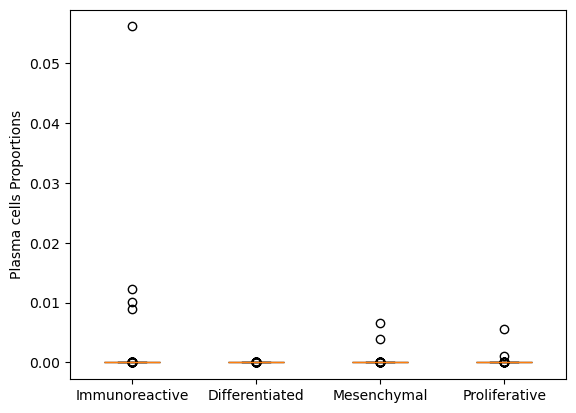

B cells


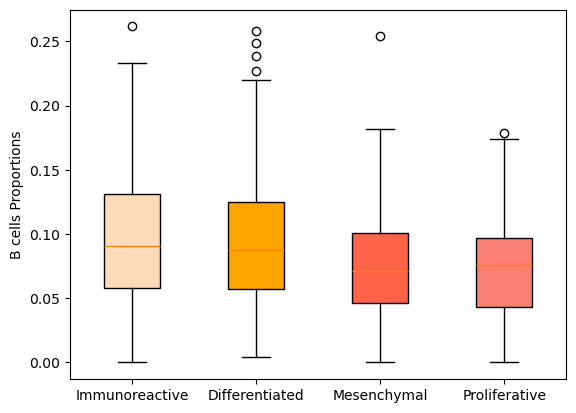

Endothelial cells


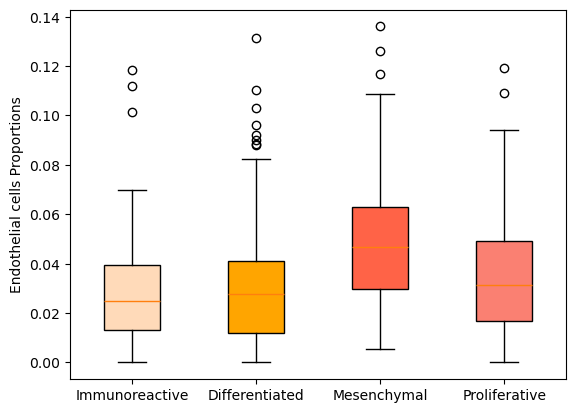

T cells


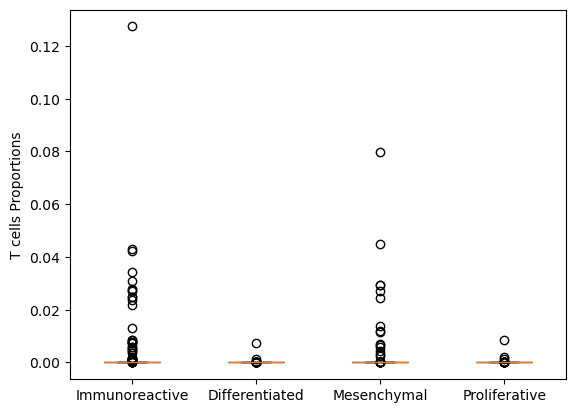

Monocytes


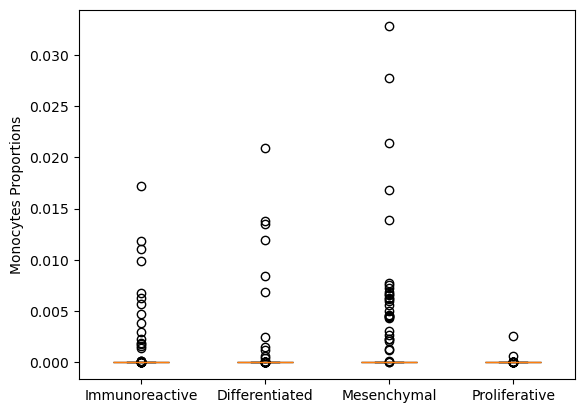

Fibroblasts


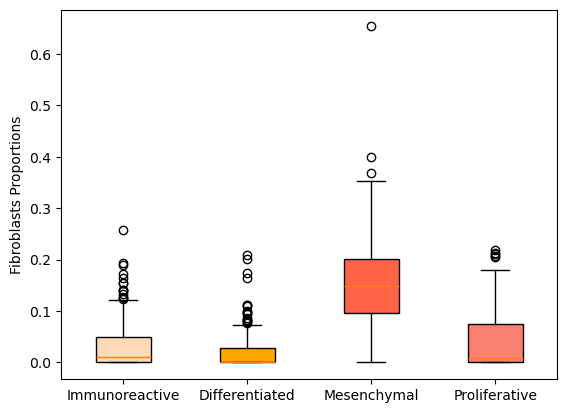

NK cells


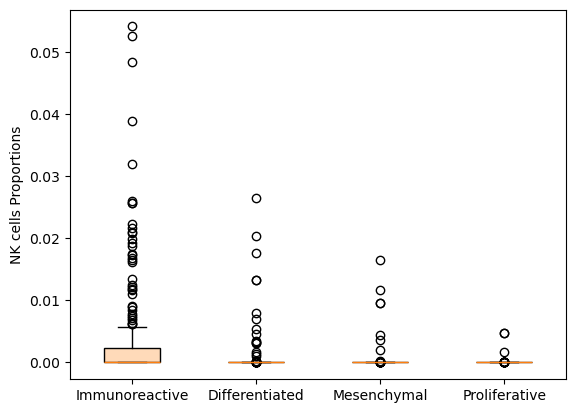

Epithelial cells


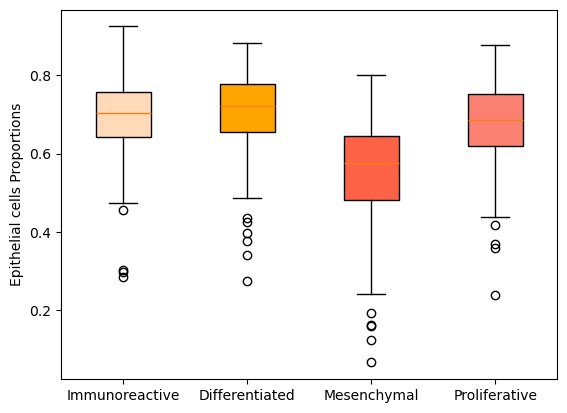

DC


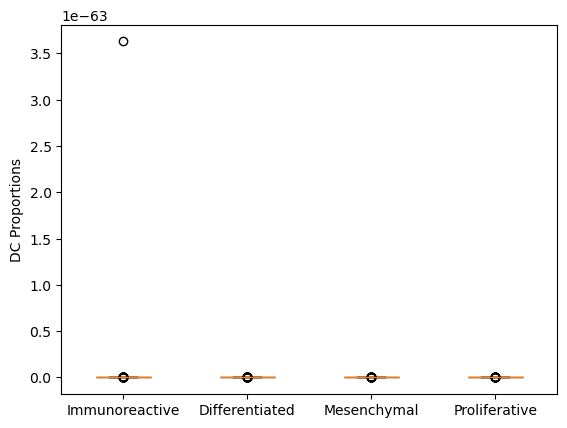

pDC


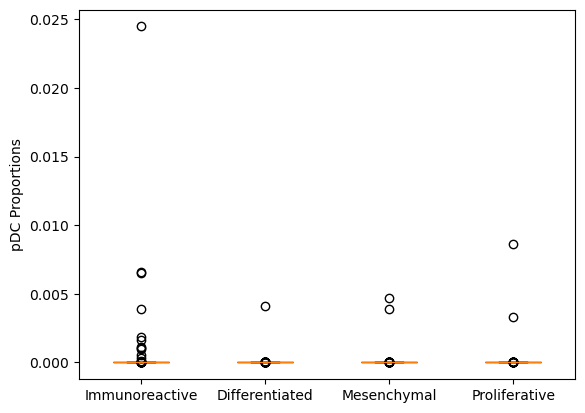

ILC


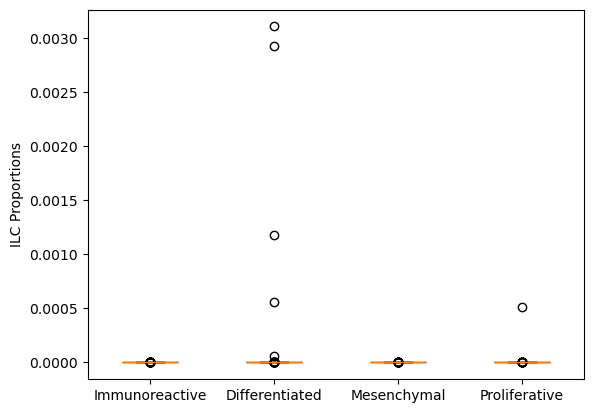

Macrophages


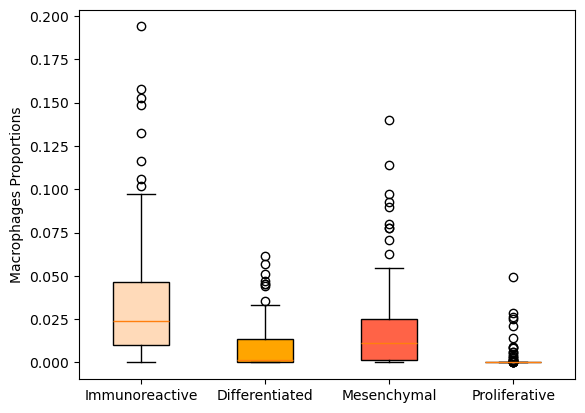

Mast cells


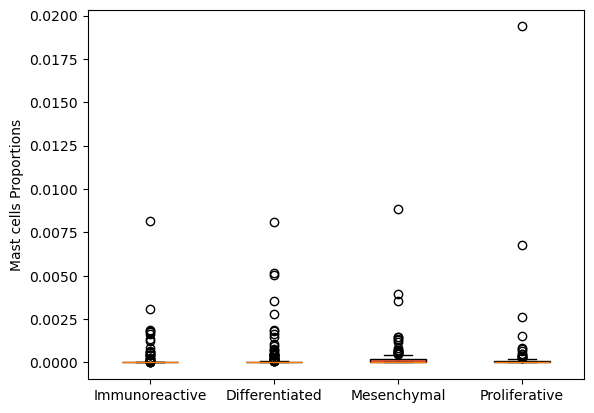

Erythroid


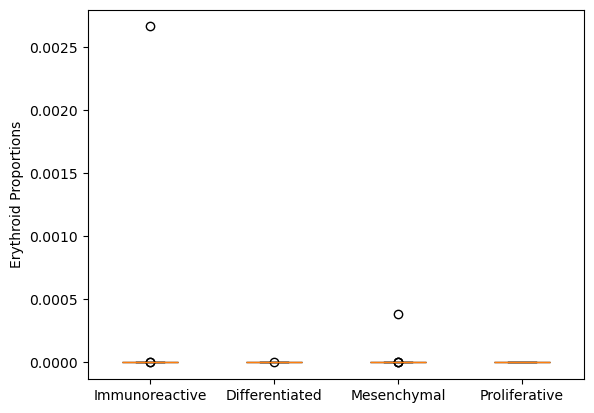

Adipocytes


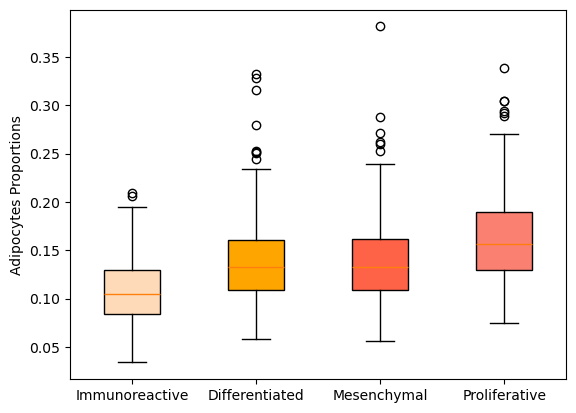

In [ ]:
subtype_list = list(subtype_map.values())
labels = subtype_list

for cell in cell_types:
    print(cell)

    om = df[df.Subtype == subtype_list[0]][cell]
    ov = df[df.Subtype == subtype_list[1]][cell]
    ovft = df[df.Subtype == subtype_list[2]][cell]
    ft = df[df.Subtype == subtype_list[3]][cell]

    values = [om, ov, ovft, ft]

    fig, ax = plt.subplots()
    ax.set_ylabel(f"{cell} Proportions")

    bplot = ax.boxplot(
        values, patch_artist=True, tick_labels=labels  # fill with color
    )  # will be used to label x-ticks

    # fill with colors
    for patch, color in zip(bplot["boxes"], colors):
        patch.set_facecolor(color)

    plt.show()

Now by group:

In [ ]:
## Which cell types to use
df["Immune"] = df[immune_cells].sum(axis=1)
df["Stromal"] = df[stromal_cells].sum(axis=1)
df["Epithelial"] = df["Epithelial cells"]

df

,ID,Age,Event,Time_Yrs,Tissue,Stage,Race,BMI,AdjTx,Residual,...,Erythroid,Adipocytes,Dataset_x,index,consensusOVsubtype,Dataset_y,Subtype,Immune,Stromal,Epithelial
0,40143,63,1,8.739220,NaN,3,1,23.218229,1.0,4.0,...,0.0,0.113422,SchildkrautW,305,IMR_consensus,SchildkrautW,Immunoreactive,0.218528,5.741863e-02,0.610632
1,41377,54,1,1.180014,NaN,3,1,17.428942,NaN,3.0,...,0.0,0.169611,SchildkrautW,458,DIF_consensus,SchildkrautW,Differentiated,0.096819,3.138082e-02,0.702189
2,41387,55,1,11.983573,NaN,3,2,45.470350,1.0,2.0,...,0.0,0.064832,SchildkrautB,24,IMR_consensus,SchildkrautB,Immunoreactive,0.086715,1.228492e-01,0.725604
3,41391,60,1,4.993840,NaN,3,1,31.340800,NaN,3.0,...,0.0,0.119373,SchildkrautW,459,DIF_consensus,SchildkrautW,Differentiated,0.107769,1.118747e-01,0.660983
4,41435,59,1,4.057495,NaN,3,1,23.922658,NaN,NaN,...,0.0,0.110333,SchildkrautW,499,IMR_consensus,SchildkrautW,Immunoreactive,0.087462,6.225249e-02,0.739953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,310266,40,0,9.702186,Fallopian Tube,3,2,28.349557,NaN,NaN,...,0.0,0.097551,SchildkrautB,206,MES_consensus,SchildkrautB,Mesenchymal,0.049467,7.507748e-02,0.777904
584,320012,66,0,11.767760,NaN,3,2,37.677475,1.0,4.0,...,0.0,0.135411,SchildkrautB,209,DIF_consensus,SchildkrautB,Differentiated,0.093217,9.157968e-51,0.771372
585,320025,60,1,6.827869,Other,3,2,38.740537,1.0,3.0,...,0.0,0.181209,SchildkrautB,210,PRO_consensus,SchildkrautB,Proliferative,0.134981,2.364402e-02,0.660166
586,320043,57,1,1.553425,NaN,3,2,19.854802,1.0,4.0,...,0.0,0.205731,SchildkrautB,211,IMR_consensus,SchildkrautB,Immunoreactive,0.201393,2.243354e-02,0.570443


Fractions are bounded (0-1), markedly right-skewed, and group sizes are often small/unequal. Heteroscedastic, non-normal data across >2 groups make the non-parametric KW test safer than one-way ANOVA without needing normality / equal-variance assumptions.

Subtype × Adipocyte / Immune / Stromal – logit-transform ANOVA + Bonferroni

In [36]:
# ─────────────────────────────────────────────────────────────────────────────
# Prep – keep rows with non-missing Subtype, add logit-transformed columns
# ─────────────────────────────────────────────────────────────────────────────
df_sub = df.copy()
print("Subtype counts:\n", df_sub["Subtype"].value_counts())
# For each, compute the logit transform
# and store it as a new column (e.g. logit_Immune).
# The logit stretches the 0–1 proportion into an unbounded scale that better meets ANOVA’s homoscedasticity / normal‑error assumptions.
for frac in fractions:
    p = df_sub[frac]
    df_sub[f"logit_{frac}"] = np.log(p / (1 - p))

Subtype counts:
 Subtype
Differentiated    179
Immunoreactive    175
Mesenchymal       130
Proliferative     104
Name: count, dtype: int64


In [ ]:
if one_way_anova:
    # ─────────────────────────────────────────────────────────────────────────────
    # Omnibus ANOVA on logit-scaled fractions
    # ─────────────────────────────────────────────────────────────────────────────
    ## fixes the order of the four subtype groups so results and plots stay consistent.
    rows = []
    for frac in fractions:
        col = f"logit_{frac}"  # run ANOVA on the logit scale
        # build one array per subtype
        groups = [df_sub.loc[df_sub["Subtype"] == lvl, col].dropna() for lvl in levels]
        # sanity check: all groups must have >= 2 points
        lengths = [len(g) for g in groups]
        print(f"{frac} group sizes: {dict(zip(levels,lengths))}")
        f_stat, p_val = f_oneway(*groups)
        print(f"{frac}: F = {f_stat:.3f}, p = {p_val:.3e}\n")
        rows.append({"Fraction": frac, "p_raw": p_val})

    # then Bonferroni‐correct just as before
    res = pd.DataFrame(rows)
    res["p_bonf"] = multipletests(res.p_raw, method="bonferroni")[1]
    res = res.sort_values("p_bonf")

    print("\n=== Omnibus ANOVA on logit fractions (Bonferroni sorted) ===")
    display(res)

elif two_way_anova:
    # ─────────────────────────────────────────────────────────────────────────────
    # 2-way ANOVA (Subtype × Race) on logit-scaled fractions
    # ─────────────────────────────────────────────────────────────────────────────

    levels_sub = levels.copy()
    levels_race = df_sub["Race"].unique().tolist()

    two_way_rows = []  # collect results for a tidy summary table

    for frac in fractions:
        col = f"logit_{frac}"
        formula = f"{col} ~ C(Subtype) * C(Race)"  # main effects + interaction
        model = smf.ols(formula, data=df_sub).fit()
        # The dataset is unbalanced—some subtype × race cells have more samples than others.
        anova = sm.stats.anova_lm(model, typ=2)  # Type-II SS (balanced for unequal n)

        # print a compact ANOVA table for this fraction
        print(f"\n=== Two-way ANOVA for {frac} ===")
        display(anova)

        # stash the p-values so you can sort/Bonferroni later if you like
        for eff in ["C(Subtype)", "C(Race)", "C(Subtype):C(Race)"]:
            two_way_rows.append(
                {
                    "Fraction": frac,
                    "Effect": eff.replace("C(", "").replace(")", ""),
                    "F": anova.loc[eff, "F"],
                    "p": anova.loc[eff, "PR(>F)"],
                }
            )

        # tidy DataFrame of all p-values (optional)
    two_way_res = pd.DataFrame(two_way_rows).sort_values(["Effect", "p"])

    # Bonferroni-correct across ALL 12 tests (4 fractions × 3 effects)
    two_way_res["p_bonf"] = multipletests(two_way_res["p"], method="bonferroni")[1]

display(two_way_res)


=== Two-way ANOVA for Adipocytes ===


,sum_sq,df,F,PR(>F)
C(Subtype),18.419683,3.0,42.956807,4.436685e-25
C(Race),0.006519,1.0,0.045606,8.309681e-01
C(Subtype):C(Race),0.114850,3.0,0.267843,8.485902e-01
Residual,82.900450,580.0,NaN,NaN



=== Two-way ANOVA for Immune ===


,sum_sq,df,F,PR(>F)
C(Subtype),35.020306,3.0,33.264979,7.522698e-20
C(Race),0.000327,1.0,0.000933,9.756428e-01
C(Subtype):C(Race),0.972797,3.0,0.924037,4.288133e-01
Residual,203.535147,580.0,NaN,NaN



=== Two-way ANOVA for Stromal ===


,sum_sq,df,F,PR(>F)
C(Subtype),1051.513144,3.0,5.561236,0.000911
C(Race),104.331191,1.0,1.655358,0.198744
C(Subtype):C(Race),48.536446,3.0,0.256699,0.856569
Residual,36555.280554,580.0,NaN,NaN



=== Two-way ANOVA for Epithelial ===


,sum_sq,df,F,PR(>F)
C(Subtype),44.223997,3.0,51.338060,1.939788e-29
C(Race),0.169460,1.0,0.590160,4.426700e-01
C(Subtype):C(Race),2.110489,3.0,2.449992,6.264446e-02
Residual,166.542576,580.0,NaN,NaN


,Fraction,Effect,F,p,p_bonf
7,Stromal,Race,1.655358,1.987445e-01,1.000000e+00
10,Epithelial,Race,0.590160,4.426700e-01,1.000000e+00
1,Adipocytes,Race,0.045606,8.309681e-01,1.000000e+00
4,Immune,Race,0.000933,9.756428e-01,1.000000e+00
9,Epithelial,Subtype,51.338060,1.939788e-29,2.327745e-28
0,Adipocytes,Subtype,42.956807,4.436685e-25,5.324021e-24
3,Immune,Subtype,33.264979,7.522698e-20,9.027238e-19
6,Stromal,Subtype,5.561236,9.114574e-04,1.093749e-02
11,Epithelial,Subtype:Race,2.449992,6.264446e-02,7.517336e-01
5,Immune,Subtype:Race,0.924037,4.288133e-01,1.000000e+00
